# Demo object and attribute predictions


### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import pylab
from skimage import transform
# display plots in this notebook
%matplotlib inline

import os

# set display defaults
plt.rcParams['figure.figsize'] = (12, 9)        # small images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [2]:
# Change dir to caffe root or prototxt database paths won't work wrong
import os
print os.getcwd()
os.chdir('..')
print os.getcwd()

/2t/jackyyeh/bottom-up-attention/tools
/2t/jackyyeh/bottom-up-attention


In [3]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
sys.path.insert(0, './caffe/python/')
sys.path.insert(0, './lib/')
sys.path.insert(0, './tools/')

import caffe

In [4]:
data_path = './data/genome/1600-400-20' # 1600 objects, 400 attributes, 20 relations

# Load classes
classes = ['__background__']
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        classes.append(object.split(',')[0].lower().strip())

# Load attributes
attributes = ['__no_attribute__']
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for att in f.readlines():
        attributes.append(att.split(',')[0].lower().strip())

In [5]:
import json 
with open('/2t/jackyyeh/sg-generator/data/VG-SGG-dicts_1600.json', 'r') as f:
    vg_1600 = json.load(f)

classes = ['__background__']
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        classes.append(object.split(',')[0].lower().strip())

# print len(vg_1600['idx_to_label'].keys())
for i in range(1600):
    print vg_1600['idx_to_label'][str(i+1)]
#     try:
#         if ',' in vg_1600['idx_to_label'][str(i+1)]:
#             print vg_1600['idx_to_label'][str(i+1)]
#     except:
#         pass
#     print vg_1600['idx_to_label'][str(i+1)],
print classes[:5]

ad
adult
advertisement
air
air conditioner
air vent
aircraft
airplane
airport
alarm clock
alley
american flag
animal
ankle
antelope
antenna
apartment
apple
apron
arch
archway
area
area rug
arm
armchair
armrest
arrow
art
artwork
asparagus
asphalt
audience
avocado
awning
baby
back
back pack
back wheel
background
backpack
backsplash
bacon
bag
bagel
balcony
ball
ball cap
balloon
bamboo
banana
banana bunch
banana peel
banana slice
band
bandana
bank
banner
bar
bark
barn
barrel
barricade
barrier
base
baseball
baseball bat
baseball cap
baseball field
baseball game
baseball glove
baseball mitt
baseball player
baseball players
baseball uniform
baseboard
baseline
basin
basket
bat
bath tub
bathing suit
bathroom
bathroom sink
bathtub
batter
beach
beach chair
beak
beam
bean
beanie
bear
beard
bed
bed frame
bedding
bedroom
bedspread
beef
beer
beer bottle
bell
belt
bench
beverage
bib
bicycle
bike
bike rack
biker
bikini
billboard
bin
bird
birthday cake
biscuit
black
blade
blanket
blazer
blender
blind
bl

KeyError: '1293'

In [6]:
# Check object extraction
from fast_rcnn.config import cfg, cfg_from_file
from fast_rcnn.test import im_detect,_get_blobs
from fast_rcnn.nms_wrapper import nms
import cv2

GPU_ID = 1   # if we have multiple GPUs, pick one 
caffe.set_device(GPU_ID)  
caffe.set_mode_gpu()
net = None
cfg_from_file('experiments/cfgs/faster_rcnn_end2end_resnet.yml')

weights = 'data/faster_rcnn_models/resnet101_faster_rcnn_final.caffemodel'
prototxt = 'models/vg/ResNet-101/faster_rcnn_end2end_final/test.prototxt'

net = caffe.Net(prototxt, caffe.TEST, weights=weights)

In [7]:
# read img_ids 
import json
with open('/2t/jackyyeh/im2p/data/image_ids/test_imgs_ids.json', 'r') as f:
    img_ids = json.load(f)

In [28]:
img_ids[0]

2352858

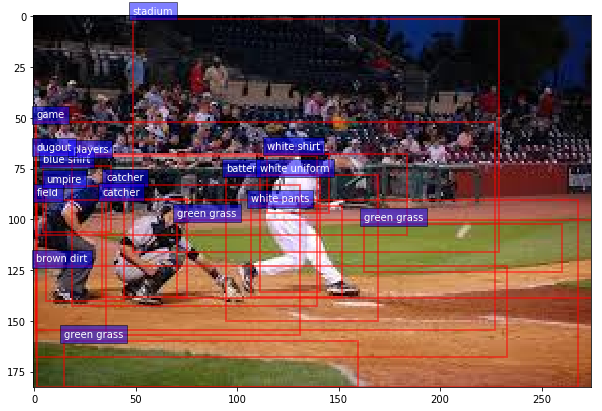

In [7]:
# im_file = '/2t/jackyyeh/im2p/data/genome/im2p_test/2411999.jpg'
im_files = ['/2t/jackyyeh/neural-motifs/vis/data/demo/jacky_demo.png']
# im_files = ['/2t/jackyyeh/im2p/data/genome/im2p_test/%d.jpg' % _id for _id in img_ids]

###########################
# Similar to get_detections_from_im
conf_thresh=0.3
min_boxes=10
max_boxes=100
n_attrs = 3

total_rois = []
total_cls = []
for im_file in im_files[:10]:
    im = cv2.imread(im_file)
    scores, boxes, attr_scores, rel_scores = im_detect(net, im)

    # Keep the original boxes, don't worry about the regression bbox outputs
    rois = net.blobs['rois'].data.copy()
    # unscale back to raw image space
    blobs, im_scales = _get_blobs(im, None)
    
#     print im.shape
#     print im_scales
#     print im_scales[0]

#     total_rois.append(rois)

    cls_boxes = rois[:, 1:5] / im_scales[0]
    cls_prob = net.blobs['cls_prob'].data
    attr_prob = net.blobs['attr_prob'].data
    pool5 = net.blobs['pool5_flat'].data

    # Keep only the best detections
    # 針對每個class去做nms
    # 每個class都會算一次全部dets box的誰該被keep，如果keep下來的那些dets的 prob有高過原本的 class' prob，就替換為新的class
    max_conf = np.zeros((rois.shape[0]))
    for cls_ind in range(1,cls_prob.shape[1]):
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])).astype(np.float32)
        keep = np.array(nms(dets, cfg.TEST.NMS))
        max_conf[keep] = np.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])

    keep_boxes = np.where(max_conf >= conf_thresh)[0]
    if len(keep_boxes) < min_boxes:
        keep_boxes = np.argsort(max_conf)[::-1][:min_boxes]
    elif len(keep_boxes) > max_boxes:
        keep_boxes = np.argsort(max_conf)[::-1][:max_boxes]
    ############################

    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (10, 10))
    plt.imshow(im)

    boxes = cls_boxes[keep_boxes]
    objects = np.argmax(cls_prob[keep_boxes][:,1:], axis=1)
    attr_thresh = 0.1
    attr = np.argmax(attr_prob[keep_boxes][:,1:], axis=1)
    attr_conf = np.max(attr_prob[keep_boxes][:,1:], axis=1)
    
#     print boxes.shape
    for i in range(len(keep_boxes)):
        bbox = boxes[i]
        
        # 只是想讓 bbox 不要貼著圖片邊框
        if bbox[0] == 0:
            bbox[0] = 1
        if bbox[1] == 0:
            bbox[1] = 1

        cls = classes[objects[i]+1]
        if attr_conf[i] > attr_thresh:
            cls = attributes[attr[i]+1] + " " + cls
        
#         print boxes[i]
#         print cls
    
        total_cls.append(cls)
        
        plt.gca().add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=2, alpha=0.5)
                )
            
        plt.gca().text(bbox[0], bbox[1] - 2,
                    '%s' % (cls),
                    bbox=dict(facecolor='blue', alpha=0.5),
                    fontsize=10, color='white')
#     print 'boxes=%d' % (len(keep_boxes))

## test code 0 (crop image with bbox)

In [50]:
boxes
total_cls

['black zebra',
 'white stripes',
 'blue sky',
 'black zebra',
 'zebra',
 'ear',
 'white ear',
 'black neck',
 'ear',
 'black eye',
 'black nose',
 'white ears',
 'head',
 'black mouth',
 'black mane',
 'head',
 'black mane',
 'black nose']

In [41]:
box = np.array([  1.,        1. ,     490.7622,  171.75024])
np.round(box).astype(int)

array([  1,   1, 491, 172])

white ear


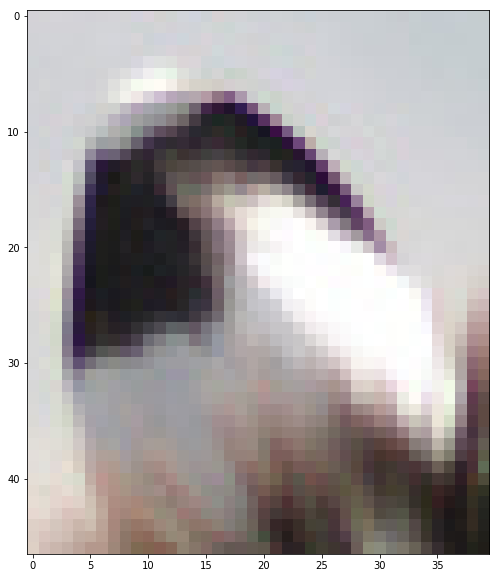

In [55]:
from IPython.display import display, Image
# im_file = '/2t/jackyyeh/im2p/data/genome/im2p_test/2411999.jpg'
im_files = ['/2t/jackyyeh/im2p/data/genome/im2p_test/%d.jpg' % _id for _id in img_ids]

###########################
# Similar to get_detections_from_im
from PIL import Image
conf_thresh=0.3
min_boxes=10
max_boxes=100
n_attrs = 3

total_rois = []

im = Image.open(im_files[0])
plt.figure(figsize = (10, 10))
plt.imshow(im)
    
for i, (box, cls) in enumerate(zip(boxes, total_cls)):

#     box = (1, 1, 1+490, 1+171)
    
    if i == 6:
    
        crop_im = im.crop( (box[0], box[1], box[2], box[3]) )

        print cls
    #     plt.figure(figsize = (10, 10))
        plt.imshow(crop_im)
    
#  'black zebra',
#  'white stripes',
#  'blue sky',
#  'black zebra',
#  'zebra',
#  'ear',
#  'white ear',
#  'black neck',
#  'ear',
#  'black eye',
#  'black nose',
#  'white ears',
#  'head',
#  'black mouth',
#  'black mane',
#  'head',
#  'black mane',
#  'black nose']  

## testing (check img_size and im_scales)

In [2]:
# read img_ids 
import json
with open('/2t/jackyyeh/im2p/data/image_ids/imgs_test_ids.json', 'r') as f:
    ids = json.load(f)

In [11]:
# im_file = '/2t/jackyyeh/im2p/data/genome/im2p_test/2411999.jpg'
im_files = ['/2t/jackyyeh/im2p/data/genome/im2p_test/%d.jpg' % _id for _id in ids]

im_scaless = []
for im_file in im_files:
    im = cv2.imread(im_file)
#     scores, boxes, attr_scores, rel_scores = im_detect(net, im)

    # Keep the original boxes, don't worry about the regression bbox outputs
#     rois = net.blobs['rois'].data.copy()
    # unscale back to raw image space
    blobs, im_scales = _get_blobs(im, None)

    print im.shape
    print im_scales
    print im_scales[0]
    raw_input()

#     im_scaless.append(im_scales[0])

(333, 500, 3)
[1.8018018]
1.8018018018018018

(496, 373, 3)
[1.60857909]
1.6085790884718498


KeyboardInterrupt: 

## testing2 (check code)

[38 38  7  7  7  8  7 38 11  8 11 11]
[39 39  8  8  8  9  8 39 12  9 12 12]
['brick' 'brick' 'white' 'white' 'white' 'green' 'white' 'brick' 'black'
 'green' 'black' 'black']


KeyboardInterrupt: 

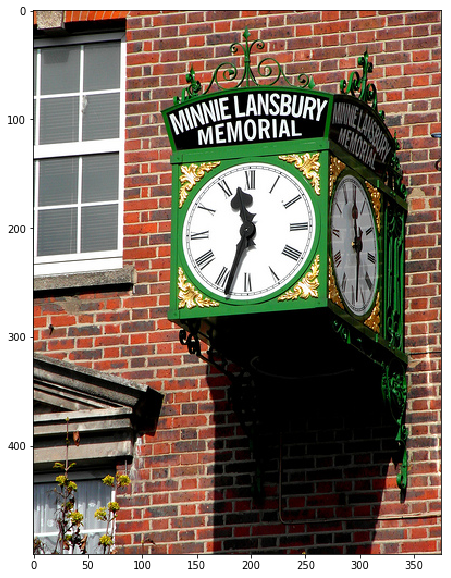

In [28]:

# im_file = 'data/demo/000542.jpg'
im_file = '/2t/jackyyeh/im2p/data/genome/im2p_test/2411999.jpg'

###########################
# Similar to get_detections_from_im
conf_thresh=0.4
min_boxes=10
max_boxes=20

im = cv2.imread(im_file)
scores, boxes, attr_scores, rel_scores = im_detect(net, im)

# Keep the original boxes, don't worry about the regression bbox outputs
rois = net.blobs['rois'].data.copy()
# unscale back to raw image space
blobs, im_scales = _get_blobs(im, None)

# print rois.shape # (138, 5)


cls_boxes = rois[:, 1:5] / im_scales[0]
cls_prob = net.blobs['cls_prob'].data
attr_prob = net.blobs['attr_prob'].data
pool5 = net.blobs['pool5_flat'].data

# Keep only the best detections
# 針對每個class去做nms
# 每個class都會算一次全部dets box的誰該被keep，如果keep下來的那些dets的 prob有高過原本的 class' prob，就替換為新的class
max_conf = np.zeros((rois.shape[0]))
for cls_ind in range(1,cls_prob.shape[1]): 
    cls_scores = scores[:, cls_ind]
    dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])).astype(np.float32)
    keep = np.array(nms(dets, cfg.TEST.NMS))
    max_conf[keep] = np.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])

keep_boxes = np.where(max_conf >= conf_thresh)[0]
if len(keep_boxes) < min_boxes:
    keep_boxes = np.argsort(max_conf)[::-1][:min_boxes]
elif len(keep_boxes) > max_boxes:
    keep_boxes = np.argsort(max_conf)[::-1][:max_boxes]
############################

im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (10, 10))
plt.imshow(im)

# print cls_prob.shape (138, 1601)

boxes = cls_boxes[keep_boxes]
objects = np.argmax(cls_prob[keep_boxes][:,1:], axis=1)
attr_thresh = 0.1
attr = np.argmax(attr_prob[keep_boxes][:,1:], axis=1)
print attr
print attr+1
print np.array(attributes)[attr+1]
raw_input()
attr_conf = np.max(attr_prob[keep_boxes][:,1:], axis=1)

# print objects.shape # (12,)
# print boxes.shape # (12, 4)

for i in range(len(keep_boxes)):
    bbox = boxes[i]
    
    # 只是想讓 bbox 不要貼著圖片邊框
    if bbox[0] == 0:
        bbox[0] = 1
    if bbox[1] == 0:
        bbox[1] = 1
        
    
    
    cls = classes[objects[i]+1]
    if attr_conf[i] > attr_thresh:
        cls = attributes[attr[i]+1] + " " + cls
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=2, alpha=0.5)
            )
    plt.gca().text(bbox[0], bbox[1] - 2,
                '%s' % (cls),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=10, color='white')
print 'boxes=%d' % (len(keep_boxes))

## testing 3

In [6]:
import glob
VG_path = '/2t/jackyyeh/dataset/VG'
im_files = glob.glob(VG_path + "/*.jpg")
im_files[:5]

['/2t/jackyyeh/dataset/VG/2355512.jpg',
 '/2t/jackyyeh/dataset/VG/2344108.jpg',
 '/2t/jackyyeh/dataset/VG/2380245.jpg',
 '/2t/jackyyeh/dataset/VG/2365464.jpg',
 '/2t/jackyyeh/dataset/VG/2326540.jpg']

In [11]:
# im_file = '/2t/jackyyeh/im2p/data/genome/im2p_test/2411999.jpg'
# im_files = ['/2t/jackyyeh/im2p/data/genome/im2p_test/%d.jpg' % _id for _id in img_ids]

###########################
# Similar to get_detections_from_im
conf_thresh=0.3
attr_thresh = 0.08
min_boxes=10
max_boxes=100

n_attrs = 3

num_rois = []
rpn_rois = []
rpn_scores = []
labels = []
attrs = []
attrs_conf = []

pointer = 0

for im_idx, im_file in enumerate(im_files):
    im = cv2.imread(im_file)
    print im
    print im_file
    scores, boxes, attr_scores, rel_scores = im_detect(net, im)

    # Keep the original boxes, don't worry about the regression bbox outputs
    rois = net.blobs['rois'].data.copy()
    # unscale back to raw image space
    blobs, im_scales = _get_blobs(im, None)
    
    cls_boxes = rois[:, 1:5] / im_scales[0]
    cls_prob = net.blobs['cls_prob'].data
    attr_prob = net.blobs['attr_prob'].data
    pool5 = net.blobs['pool5_flat'].data

    # Keep only the best detections
    # 針對每個class去做nms
    # 每個class都會算一次全部dets box的誰該被keep，如果keep下來的那些dets的 prob有高過原本的 class' prob，就替換為新的class
    max_conf = np.zeros((rois.shape[0]))
    for cls_ind in range(1,cls_prob.shape[1]):
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])).astype(np.float32)
        keep = np.array(nms(dets, cfg.TEST.NMS))
        max_conf[keep] = np.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])

    keep_boxes = np.where(max_conf >= conf_thresh)[0]
    if len(keep_boxes) < min_boxes:
        keep_boxes = np.argsort(max_conf)[::-1][:min_boxes]
    elif len(keep_boxes) > max_boxes:
        keep_boxes = np.argsort(max_conf)[::-1][:max_boxes]
    ############################

    boxes = cls_boxes[keep_boxes]
    objects = np.argmax(cls_prob[keep_boxes][:,1:], axis=1)

    
#     attr = np.argmax(attr_prob[keep_boxes][:,1:], axis=1)
#     attr_conf = np.max(attr_prob[keep_boxes][:,1:], axis=1)
    
    #     get top n_attrs of attributes    
    attr = np.argsort(attr_prob[keep_boxes][:,1:], axis=1)[:, -n_attrs:]
    attr_conf = np.sort(attr_prob[keep_boxes][:,1:], axis=1)[:, -n_attrs:]
        
    rois[:, 1:5] = rois[:, 1:5] / im_scales[0]
    num_rois.append( len(rois[keep_boxes]) )
    rpn_rois.append( rois[keep_boxes] )
    rpn_scores.append( max_conf[keep_boxes] )
    labels.append( objects )
    attrs.append( attr )
    attrs_conf.append( attr_conf )
    
    if (im_idx+1) % 1000 == 0:
        print im_idx+1
    

#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     plt.figure(figsize = (10, 10))
#     plt.imshow(im)

    
#     for i in range(len(keep_boxes)):
#         bbox = boxes[i]

#         # 只是想讓 bbox 不要貼著圖片邊框
#         if bbox[0] == 0:
#             bbox[0] = 1
#         if bbox[1] == 0:
#             bbox[1] = 1

#         cls = classes[objects[i]+1]
        
#         for _attr, _attr_conf in zip(attr[i], attr_conf[i]):
#             if _attr_conf > attr_thresh:
#                 cls = attributes[_attr+1] + " " + cls
    
#         plt.gca().add_patch(
#             plt.Rectangle((bbox[0], bbox[1]),
#                           bbox[2] - bbox[0],
#                           bbox[3] - bbox[1], fill=False,
#                           edgecolor='red', linewidth=2, alpha=0.5)
#                 )
#         plt.gca().text(bbox[0], bbox[1] - 2,
#                     '%s' % (cls),
#                     bbox=dict(facecolor='blue', alpha=0.5),
#                     fontsize=10, color='white')
#     print 'boxes=%d' % (len(keep_boxes))


[[[102  97  99]
  [103  99  98]
  [104  99 100]
  ...
  [209 203 196]
  [208 202 195]
  [210 204 197]]

 [[102  95  98]
  [105 101  96]
  [106 101  98]
  ...
  [210 204 197]
  [209 203 196]
  [210 204 197]]

 [[106 101 100]
  [107 101  96]
  [109 102  99]
  ...
  [210 204 197]
  [209 203 196]
  [210 204 197]]

 ...

 [[ 78  98 123]
  [ 73 103 128]
  [ 81 108 135]
  ...
  [ 94  98  99]
  [ 99 103 104]
  [ 99 103 104]]

 [[ 74  89 115]
  [ 73  99 123]
  [ 78 103 129]
  ...
  [ 93  97  98]
  [ 95  99 100]
  [ 92  96  97]]

 [[ 71  84 110]
  [ 64  88 112]
  [ 63  88 114]
  ...
  [ 92  96  97]
  [ 93  98  97]
  [ 91  96  95]]]
/2t/jackyyeh/dataset/VG/2371618.jpg
None
/2t/jackyyeh/dataset/VG/2416776.jpg


AttributeError: 'NoneType' object has no attribute 'astype'

## merge bbox_label_attr

In [93]:
import pickle

data = {}

path = '/2t/jackyyeh/bottom-up-attention/VG_bbox_label_attr_0to50000.pkl'
with open(path, 'r') as f:
    d1 = pickle.load(f)

path2 = '/2t/jackyyeh/bottom-up-attention/VG_bbox_label_attr_50000to108249.pkl'
with open(path2, 'r') as f:
    d2 = pickle.load(f) 
    
keys = ['img_ids', 'num_rois', 'boxes', 'labels', 'attrs', 'attrs_conf']

for key in keys:
    d1[key].extend( d2[key] )

o_path = '/2t/jackyyeh/bottom-up-attention/VG_bbox_label_attr.pkl'
with open(o_path, 'w') as f:
    pickle.dump(d1, f)


In [95]:
import json
with open('/2t/jackyyeh/im2p/data/image_ids/sg_imgs_ids.json', 'w') as f:
    json.dump(d1['img_ids'], f)